In [1]:
import torch
import ml_collections
import time
import os
import json
from datetime import datetime
import pickle
from torch import nn, Tensor
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import numpy as np
from models import MLP1, TransformerDenoiser
from promoter_model import WrappedModel
from model import Transformer
from dna_model import CNNModel
import hydra
from omegaconf import DictConfig, OmegaConf
from utils.promoter_dataset import PromoterDataset 
from selene_sdk.utils import NonStrandSpecific
from promoter_model import PromoterModel
from utils.sei import Sei
from utils.esm import upgrade_state_dict
import pandas as pd
import random
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

g = torch.Generator()
g.manual_seed(42)


/home/hmuhammad/.conda/envs/flow_matching/lib/python3.9/site-packages/selene_sdk/sequences/genome.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
device = 'cuda:0'

def get_sei_profile(seq_one_hot,seifeatures,sei,device):
    seq_one_hot = seq_one_hot[:, :, :4] 
    B, L, K = seq_one_hot.shape
    sei_inp = torch.cat([torch.ones((B, 4, 1536), device=device) * 0.25,
                             seq_one_hot.transpose(1, 2),
                             torch.ones((B, 4, 1536), device=device) * 0.25], 2) # batchsize x 4 x 4,096
    with torch.no_grad():
        sei_out = sei(sei_inp).cpu().detach().numpy() # batchsize x 21,907
    return sei_out

def seed_worker(worker_id):
    """Seed each worker for reproducibility with num_workers > 0"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seifeatures = pd.read_csv('data/promoter_design/target.sei.names', sep='|', header=None)

# Load SEI model
sei = NonStrandSpecific(Sei(4096, 21907))
sei.load_state_dict(upgrade_state_dict(
        torch.load('data/promoter_design/best.sei.model.pth.tar', map_location=device, weights_only=False)['state_dict'],
        prefixes=['module.']))
sei.to(device)
sei.eval()

# Load your generated samples
allsamples = np.load('allsamples.npy')  # shape: (5, 7497, 1024)
num_samples, num_seqs, seq_len = allsamples.shape

batch_size = 128  # process SEI in batches to avoid memory issues
allsamples_pred = np.zeros((5, num_seqs, 21907))
testsamples_pred = np.zeros(( num_seqs, 21907))

with torch.no_grad():
    for j in range(num_samples):  # 5 independent generations
        print("set",j)
        for i in range(0, num_seqs, batch_size):
            batch = allsamples[j, i:i+batch_size] # [Batch_size,seq_length]
            batch_tensor = torch.tensor(batch,dtype=torch.long).to(device)
            seq_pred_one_hot = torch.nn.functional.one_hot(batch_tensor, num_classes=5).float()
            sei_out = get_sei_profile(seq_pred_one_hot,seifeatures=seifeatures,sei=sei,device=device)
            allsamples_pred[j, i:i+batch_size] = sei_out





set 0
set 1
set 2
set 3
set 4


In [3]:
h3k4_idx = seifeatures[1].str.strip().values == 'H3K4me3'
allsamples_pred_h3k4me3 = allsamples_pred[:, :, h3k4_idx].mean(axis=2)  # (5, 7497)

In [4]:
test_ds = PromoterDataset(split="test", n_tsses=100000, rand_offset=0) #pytorch dataset object, 7497 sequences for test
test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=True,  # Must be True with generator!
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    generator=g,
    worker_init_fn=seed_worker
)

total_test_samples = 7497
current_idx = 0
test_datasets=[]
with torch.no_grad():  
    for batch in test_loader:
        test_datasets.append(batch)
        seq_one_hot = batch[:,:,:4].to(device) #(B,1024,4)
        sei_profile=get_sei_profile(seq_one_hot,seifeatures=seifeatures,sei=sei,device=device)
        testsamples_pred[current_idx:current_idx + 256] = sei_profile
        current_idx += 256

testseqs_pred_h3k4me3 = testsamples_pred[:, h3k4_idx].mean(axis=1)  # (7497)


Initializing Genome
Finished Initializing Genome


/home/hmuhammad/.conda/envs/flow_matching/lib/python3.9/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
#print(test_ds.shape)
exp=(10**np.concatenate(test_datasets, axis=0)[:,12:-12,4]-1).sum(axis=-1)
exp1 = (10**np.concatenate(test_datasets, axis=0)[:,:,4]-1).sum(axis=-1)
exp2 = (np.concatenate(test_datasets, axis=0)[:,:,4]-1).sum(axis=-1)
exp3 = (np.concatenate(test_datasets, axis=0)[:,:,4]).sum(axis=-1)

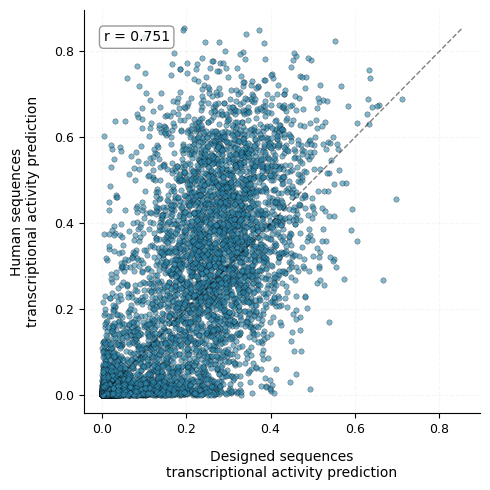

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # Square, single column width

# Extract data
x_data = allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1).mean(0)
y_data = testsamples_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

# Scatter with improved styling
scatter = ax.scatter(x_data, y_data, 
                     s=15,  # Smaller points
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.3,
                     c='#2E86AB')  # Nice blue color

# Add 1:1 line for reference
lims = [min(x_data.min(), y_data.min()), max(x_data.max(), y_data.max())]
ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1, label='y = x')

# Labels with publication styling
ax.set_xlabel('Designed sequences\ntranscriptional activity prediction', fontsize=10, labelpad=10)
ax.set_ylabel('Human sequences\ntranscriptional activity prediction', fontsize=10, labelpad=10)

# Calculate and display correlation
corr = np.corrcoef(x_data, y_data)[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', 
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))

# Clean styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.grid(True, alpha=0.1, linestyle='--')

plt.tight_layout()

# Save for paper
fig.savefig('figures/fig3c_h3k4me3_correlation.pdf',
            dpi=600,
            bbox_inches='tight',
            pad_inches=0.05,
            transparent=False)

plt.show()

In [7]:
# Compute MSE per generation
acc = []
for i in range(5):
    acc.append(((allsamples_pred_h3k4me3[i] - testseqs_pred_h3k4me3)**2).mean())
mean_mse = np.mean(acc)
stderr_mse = np.std(acc)/np.sqrt(4)
print(acc)

print("Mean MSE:", mean_mse, "StdErr:", stderr_mse)

[0.02829739494370629, 0.029540882943955318, 0.02978898814934375, 0.028609165810590097, 0.0283726660390084]
Mean MSE: 0.028921819577320772 StdErr: 0.00031019742856523886


In [8]:
import rpy2
%load_ext rpy2.ipython

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /home/hmuhammad/.conda/envs/flow_matching/lib/R
INFO:rpy2.situation:R library path: 
INFO:rpy2.situation:LD_LIBRARY_PATH: 
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


In [9]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [10]:
print(testseqs_pred_h3k4me3.shape)
print(allsamples_pred_h3k4me3.shape)
print(exp2.shape)

(7497,)
(5, 7497)
(7497,)


In [11]:
import numpy as np
import pandas as pd

# Calculate correlations
#exp_log = np.log10(1 + exp)
exp_log=exp2
corr_human = np.corrcoef(exp_log, testseqs_pred_h3k4me3)[0, 1]
corr_designed = np.corrcoef(exp_log, allsamples_pred_h3k4me3[0])[0, 1]
corr_designed_human = np.corrcoef(testseqs_pred_h3k4me3, allsamples_pred_h3k4me3[0])[0, 1]

print(f"Correlation log10(1+exp) vs human pred: {corr_human:.4f}")
print(f"Correlation log10(1+exp) vs designed pred: {corr_designed:.4f}")
print(f"human_pred vs designed pred: {corr_designed_human:.4f}")

Correlation log10(1+exp) vs human pred: 0.4629
Correlation log10(1+exp) vs designed pred: 0.4170
human_pred vs designed pred: 0.6475


=== VALUE RANGES ===
testseqs range: [0.000029, 0.853754]
allsamples[0] range: [0.000039, 0.805370]
exp range: [0.056462, 98.259766]

=== AFTER DIVIDING BY 0.004138 ===
testseqs/0.004138 range: [0.007, 206.320]
allsamples/0.004138 range: [0.009, 194.628]

=== BASELINE COMPARISON ===
Are values above 1? testseqs: 74.4%
Are values above 1? allsamples: 77.4%


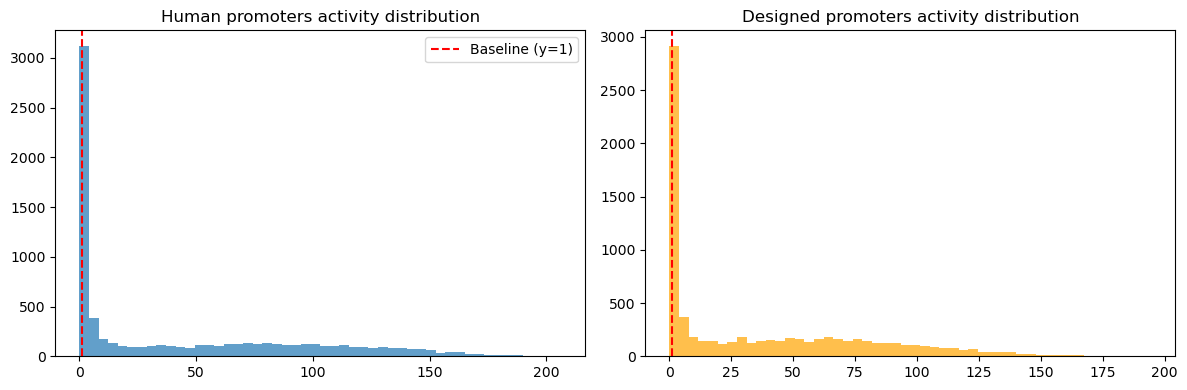

In [30]:
import numpy as np
import matplotlib.pyplot as plt

print("=== VALUE RANGES ===")
print(f"testseqs range: [{testseqs_pred_h3k4me3.min():.6f}, {testseqs_pred_h3k4me3.max():.6f}]")
print(f"allsamples[0] range: [{allsamples_pred_h3k4me3[0].min():.6f}, {allsamples_pred_h3k4me3[0].max():.6f}]")
print(f"exp range: [{exp3.min():.6f}, {exp3.max():.6f}]")

print(f"\n=== AFTER DIVIDING BY 0.004138 ===")
print(f"testseqs/0.004138 range: [{(testseqs_pred_h3k4me3/0.004138).min():.3f}, {(testseqs_pred_h3k4me3/0.004138).max():.3f}]")
print(f"allsamples/0.004138 range: [{(allsamples_pred_h3k4me3[0]/0.004138).min():.3f}, {(allsamples_pred_h3k4me3[0]/0.004138).max():.3f}]")

print(f"\n=== BASELINE COMPARISON ===")
print(f"Are values above 1? testseqs: {(testseqs_pred_h3k4me3/0.004138 > 1).mean()*100:.1f}%")
print(f"Are values above 1? allsamples: {(allsamples_pred_h3k4me3[0]/0.004138 > 1).mean()*100:.1f}%")

# Quick histogram to see distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(testseqs_pred_h3k4me3/0.004138, bins=50, alpha=0.7)
axes[0].axvline(1, color='red', linestyle='--', label='Baseline (y=1)')
axes[0].set_title('Human promoters activity distribution')
axes[0].legend()

axes[1].hist(allsamples_pred_h3k4me3[0]/0.004138, bins=50, alpha=0.7, color='orange')
axes[1].axvline(1, color='red', linestyle='--', label='Baseline (y=1)')
axes[1].set_title('Designed promoters activity distribution')

#axes[2].hist(exp, bins=50, alpha=0.7, color='green')
#axes[2].set_title('Experimental expression (exp)')
plt.tight_layout()
fig.savefig(
    'figures/promoter_activity_histograms.pdf',
    format='pdf',
    dpi=600,  # High DPI for publications
    bbox_inches='tight',  # Removes extra white space
    facecolor='white',  # White background
    edgecolor='none'    # No border
)
plt.show()

In [13]:
exp1 = exp  


  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    750     750     749     750     750     749     750     749     750     750 
Saving 10 x 6 in image


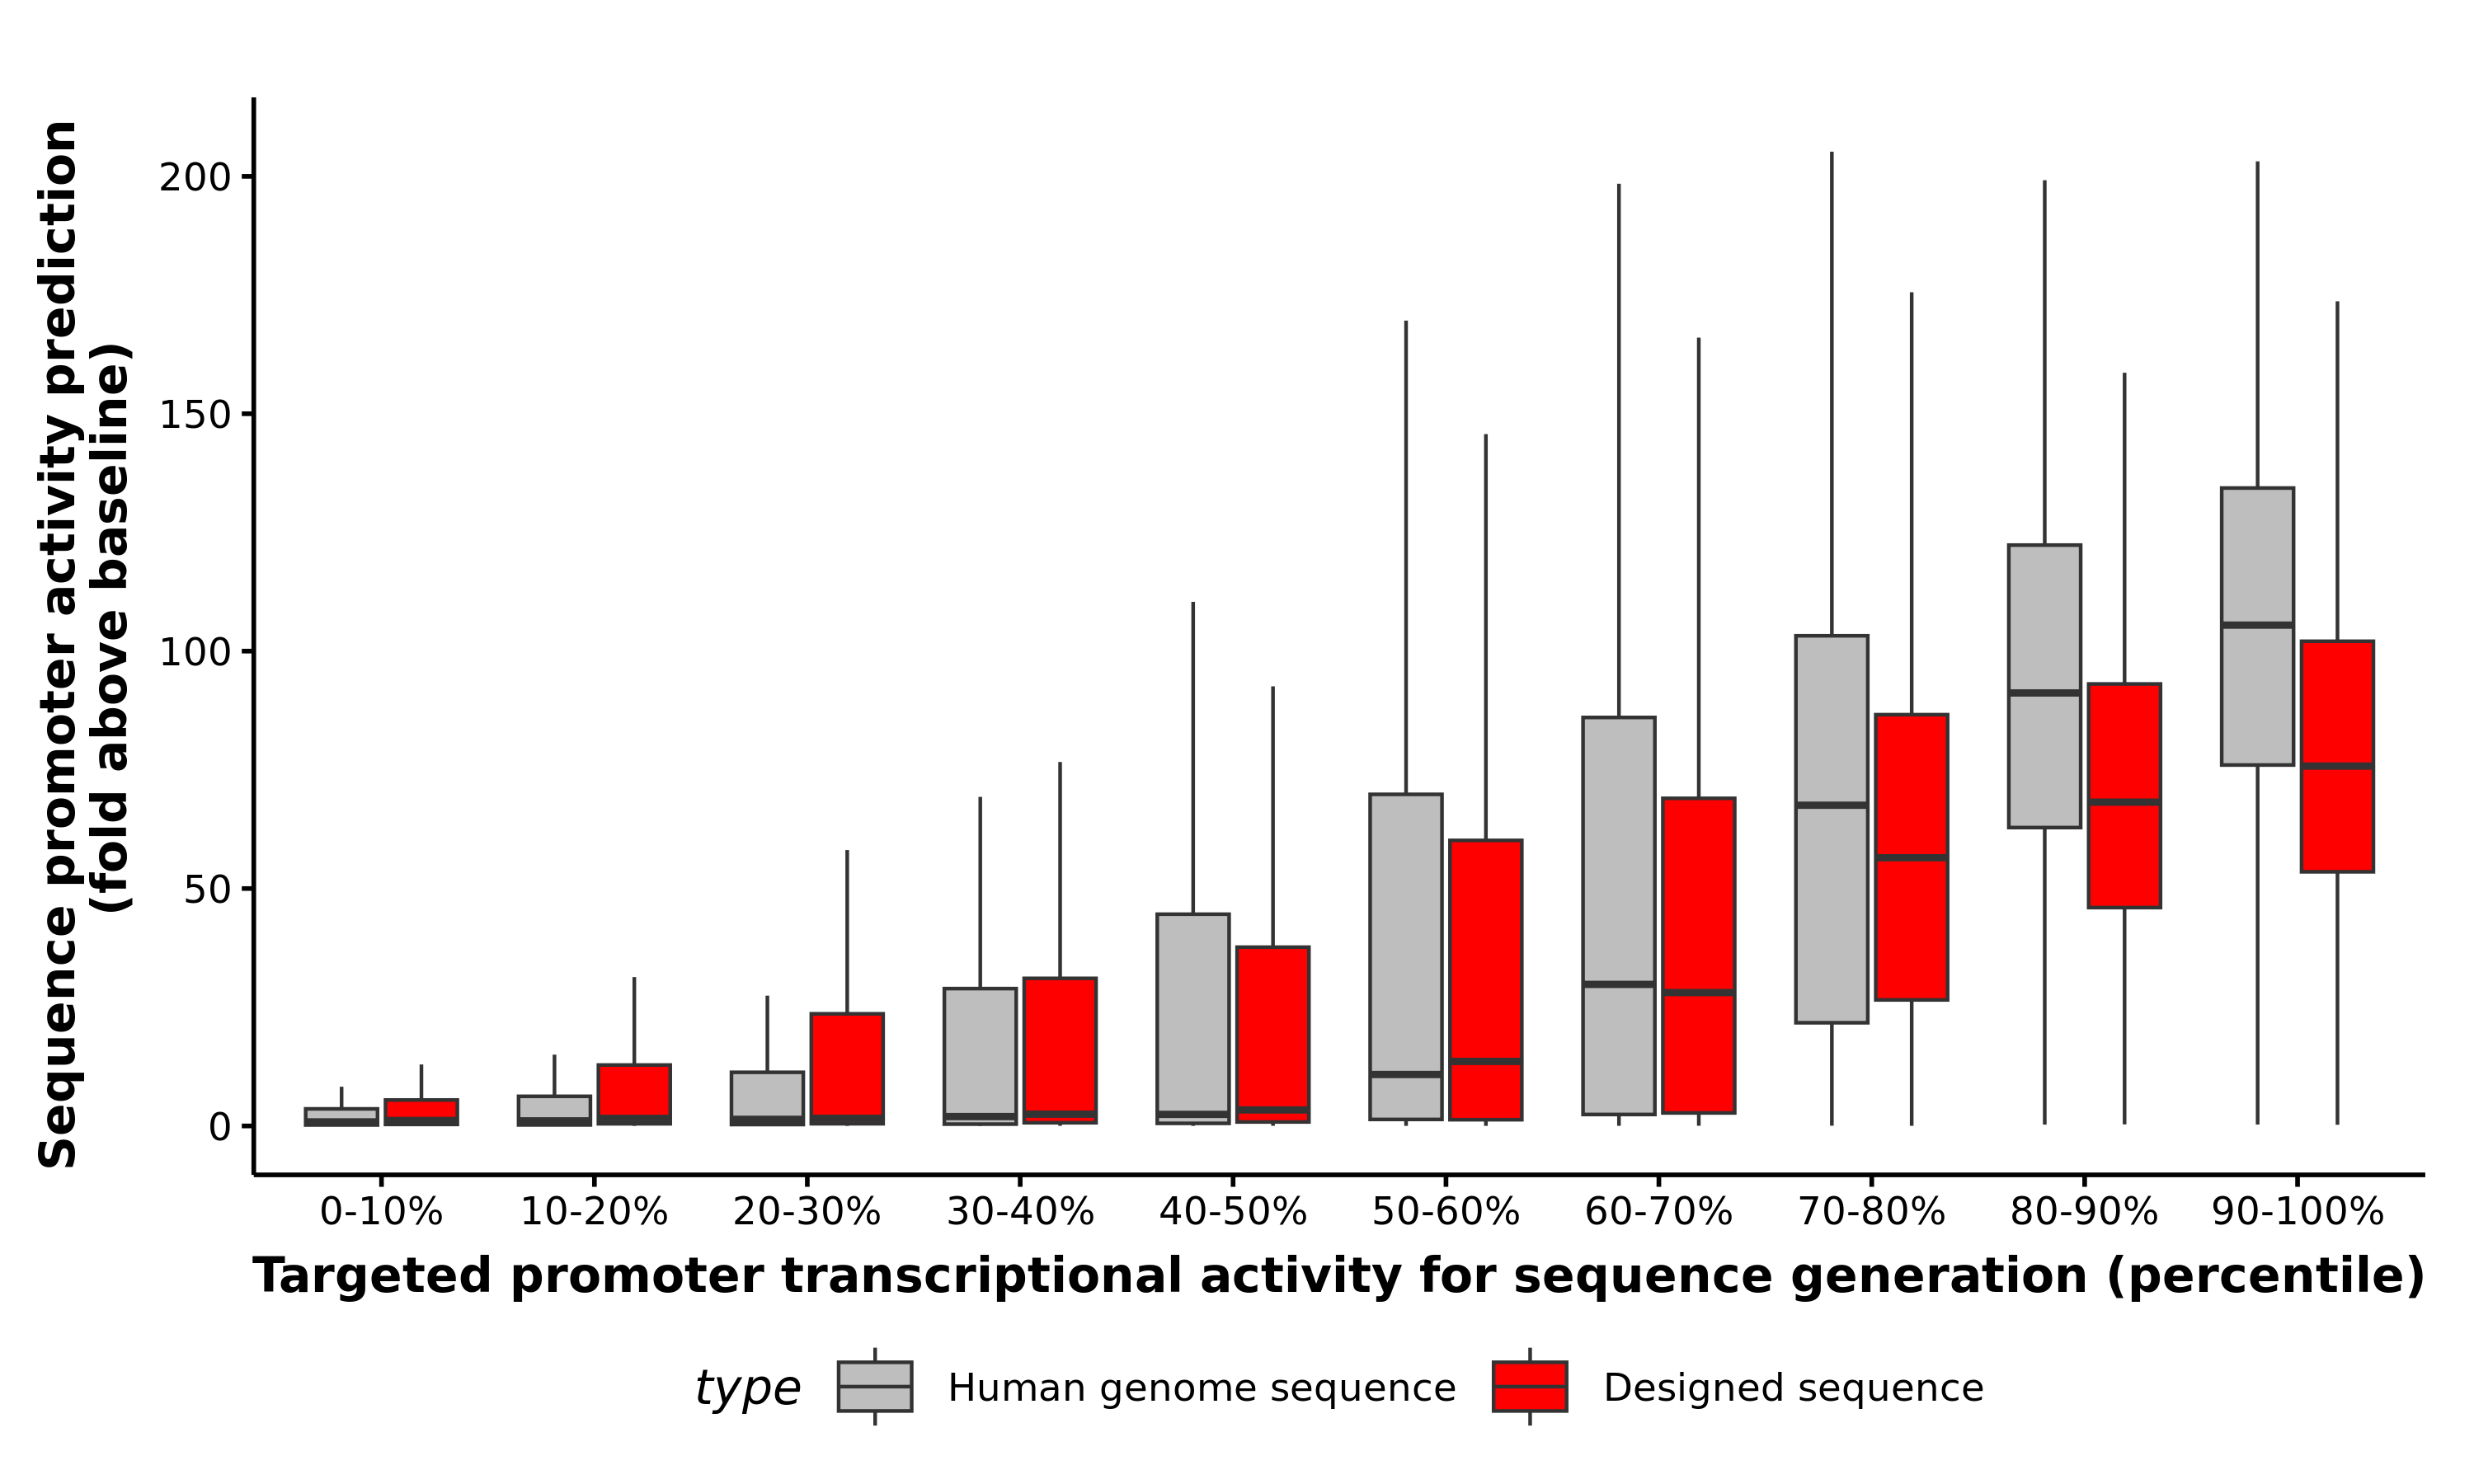

In [14]:
%%R -i testseqs_pred_h3k4me3,allsamples_pred_h3k4me3,exp1 -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp1))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp1)), y=testseqs_pred_h3k4me3/0.004138, type='Human genome sequence'),
      data.frame(x=cutp(log10(1+exp1)), y=allsamples_pred_h3k4me3[1,]/0.004138, type='Designed sequence'))
plotdata$type = factor(plotdata$type, levels=c('Human genome sequence', 'Designed sequence'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red'))
ggsave('compare_seqs.pdf', device=cairo_pdf)
p

In [15]:
testseqs_scpred = testseqs_pred_h3k4me3
allsamples_scpred = allsamples_pred_h3k4me3

In [16]:

allsamples = torch.tensor(allsamples,dtype=torch.long).to(device)
allsamples = torch.nn.functional.one_hot(allsamples, num_classes=5).float()
sample_bp = allsamples[0,:,:,:].mean(axis=0).cpu()
testseqs = np.concatenate(test_datasets, axis=0)[:,:,:4]
testseqs_bp = testseqs.mean(axis=0)

In [22]:
print(allsamples.shape)
print(sample_bp.shape)

torch.Size([5, 7497, 1024, 5])
torch.Size([1024, 5])


In [23]:
# Convert to standard float64 numpy arrays
sample_bp_fixed = np.ascontiguousarray(sample_bp[:,0:4].numpy() if hasattr(sample_bp, 'numpy') else sample_bp, dtype=np.float64)
testseqs_bp_fixed = np.ascontiguousarray(testseqs_bp, dtype=np.float64)

# Check shapes
print(f"sample_bp_fixed shape: {sample_bp_fixed.shape}, dtype: {sample_bp_fixed.dtype}")
print(f"testseqs_bp_fixed shape: {testseqs_bp_fixed.shape}, dtype: {testseqs_bp_fixed.dtype}")

sample_bp_fixed shape: (1024, 4), dtype: float64
testseqs_bp_fixed shape: (1024, 4), dtype: float64


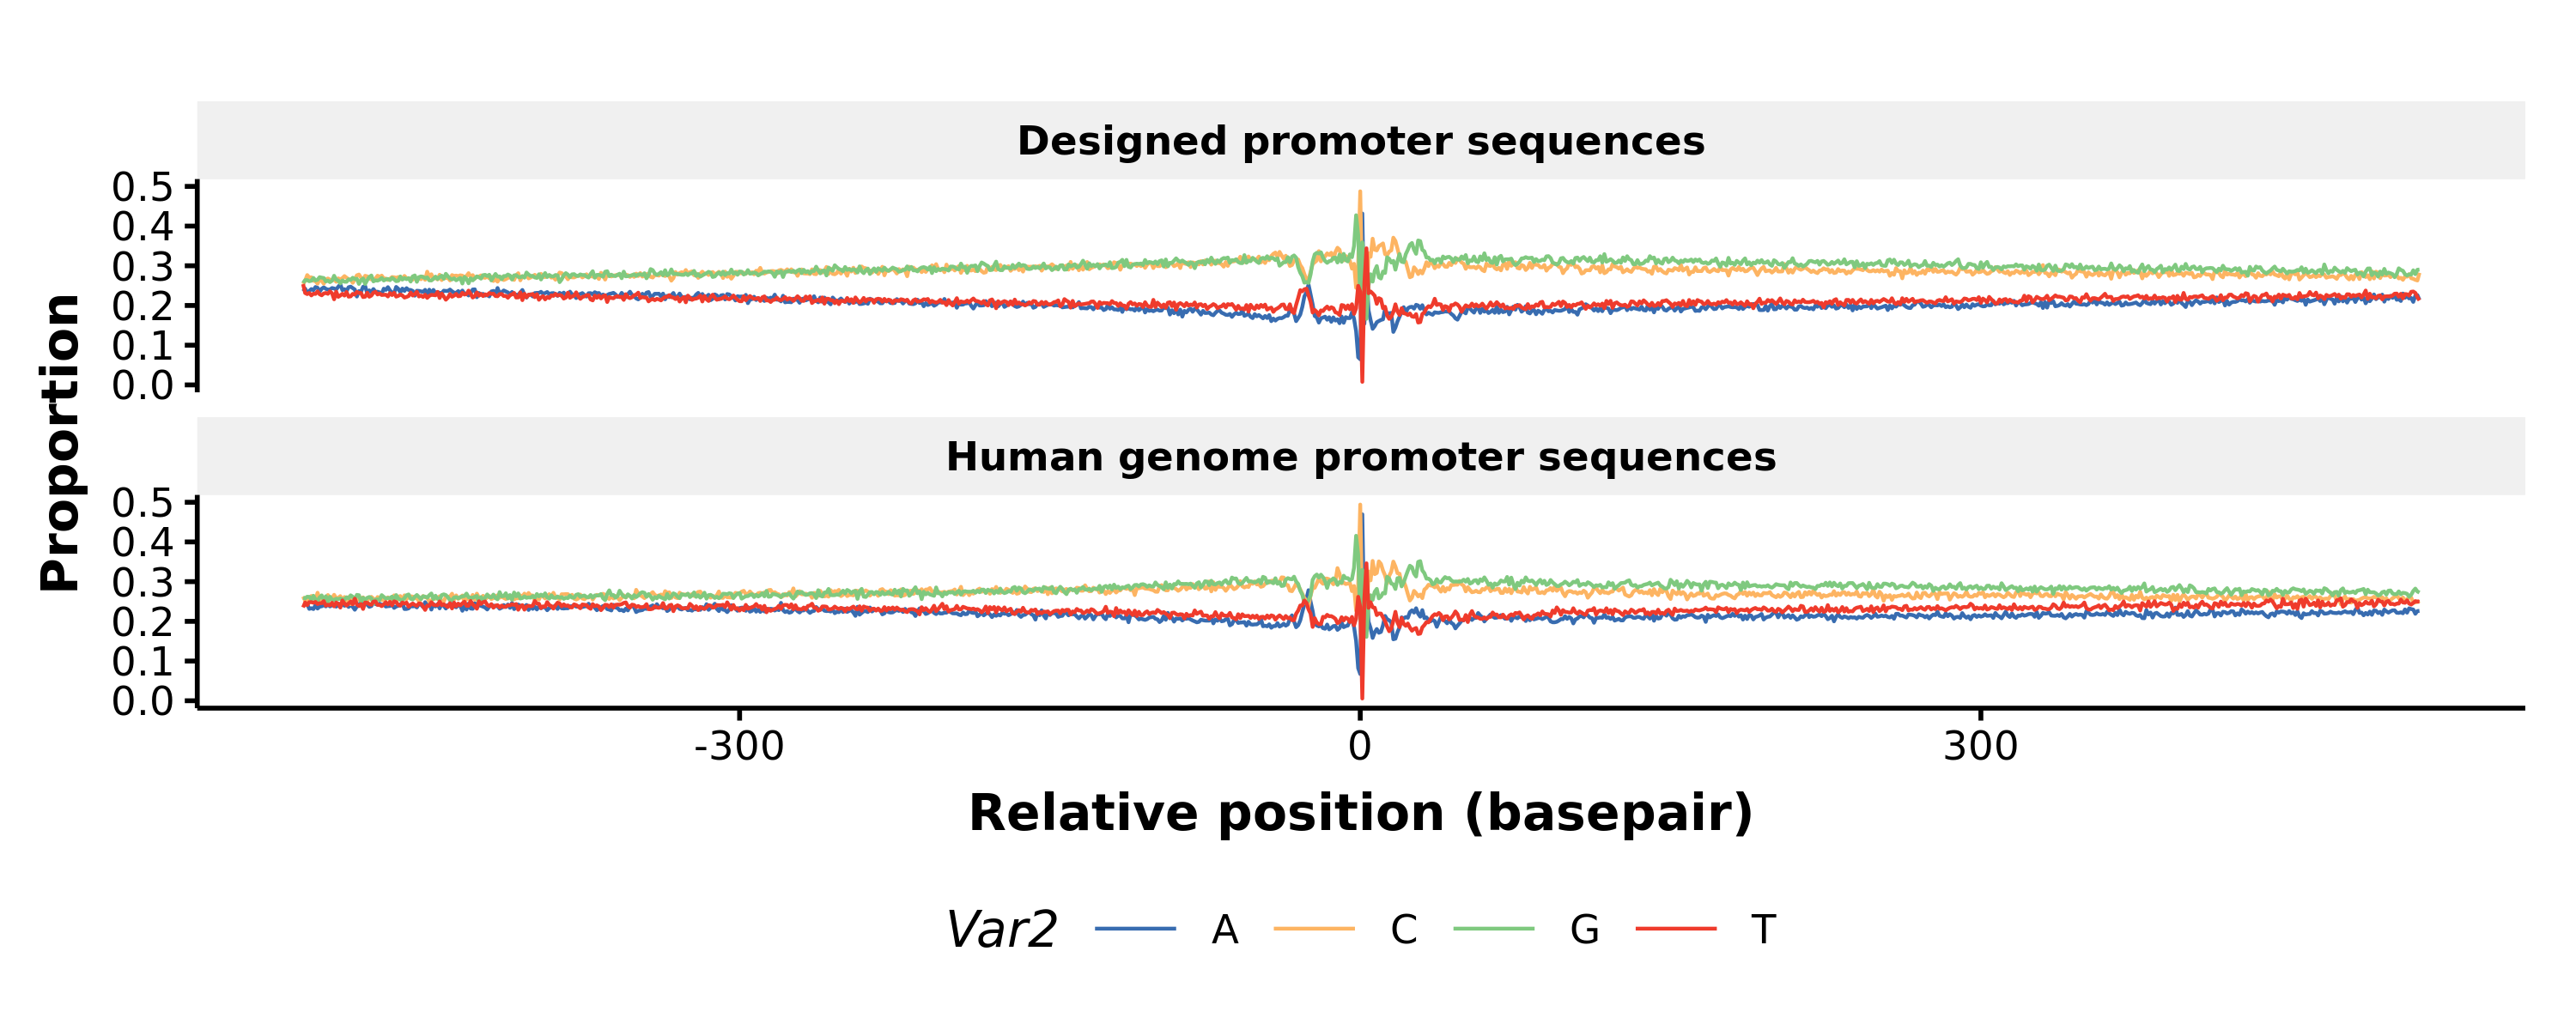

In [26]:
%%R -i sample_bp_fixed,testseqs_bp_fixed -w 10 -h 4 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp_fixed) = c('A','C','G','T')
colnames(testseqs_bp_fixed) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp_fixed),type='Designed promoter sequences'), 
                 cbind(melt(testseqs_bp_fixed),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=2)+xlab('Relative position (basepair)') + ylab('Proportion')
ggsave('sequence_base_composition.pdf', plot=p, width=10, height=4, units='in', 
       device=cairo_pdf, dpi=300)
p

In [19]:
%%R -i exp,bpds1  -w 7.5 -h 4 --unit in --res 300
cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}
qplot(cutp(exp), bpds1, geom='boxplot', notch=T, outlier.shape=NA)+
    theme_Publication()+ylab('NLL (bits per dimension)')+xlab('Promoter expression level (percentile)')
# ggsave('./figures/seqs_nll.pdf', device=cairo_pdf)

NameError: name 'bpds1' is not defined.